# Étape 1 : Conception de la classe et du choix des méthodes de sélection, de croisement et de mutation

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from abc import ABC, abstractmethod
import time

## ParameterSetting Classe
Dans cette classe, nous définissons les paramètres de base du problème du sac à dos :

- n : le nombre d'objets que le sac à dos peut contenir.
- k : le nombre de contraintes.
- population_size : le nombre d'individus dans chaque génération.

Nous générons aléatoirement :

- le budget pour chaque contrainte,
- la valeur d'utilité de chaque objet,
- le coût de chaque objet.

In [9]:
class ParameterSetting:
    def __init__(self, n, k, population_size):
        self.n = n  # Le nombre d'objets
        self.k = k  # Le nombre de contraintes
        self.population_size = population_size  # Le nombre d'individus par génération
        np.random.seed(1)  # Pour des résultats reproductibles
        self.B = np.random.randint(100, 200, size=(self.k))  # Budget pour chaque contrainte
        self.utilities = np.random.randint(1, 100, size=self.n)  # Valeur d'utilité de chaque objet
        self.costs = np.random.randint(1, 20, size=(self.n, self.k))  # Coût de chaque objet
    
    def print_info(self):
        # Affiche les budgets et la liste des objets.
        cost_columns = [f"cost_{i+1}" for i in range(self.k)]
        print("Liste de budgets:")
        print(self.B)
        df = pd.DataFrame(
            np.column_stack((self.utilities, self.costs)),
            columns=["utilities"] + cost_columns,
        )
        print("Liste d'objets:")
        print(df)

## Population classe
Une population représente plusieurs individus, chaque individu pouvant être considéré comme une solution, c'est-à-dire un ensemble où chaque individu respecte toutes les contraintes. Les caractéristiques suivantes de la population sont celles qui nous intéressent :

- Fitness moyenne (fitness_moyen) : La moyenne des scores de fitness de tous les individus de la population.
- Fitness maximale (fitness_max) : Le score de fitness le plus élevé parmi tous les individus.
- Meilleur individu (best_individual) : L'individu ayant le score de fitness le plus élevé.
- Variation de fitness (fitness_variation) : La variance des scores de fitness de la population.

In [5]:
class Population:
    """
    Cette classe représente une population d'individus pour un algorithme génétique.

    Attributs:
        size (int): La taille de la population.
        individuals (array-like): Les individus de la population.
        fitness_func (function): La fonction d'évaluation de la fitness des individus.
        fitness_scores (numpy array): Les scores de fitness des individus de la population.
    """
    def __init__(self, size, individuals, fitness_func):
        """
            Initialise une nouvelle instance de la classe Population.

            Args:
                size (int): La taille de la population.
                individuals (array-like): Les individus de la population.
                fitness_func (function): La fonction d'évaluation de la fitness des individus.
        """
        self.size = size
        self.individuals = individuals
        self.fitness_func = fitness_func  
        self.fitness_scores = np.zeros(size)
        self.evaluate_fitness()

    def evaluate_fitness(self):
        self.fitness_scores = np.array([self.fitness_func(ind) for ind in self.individuals])

    def get_max_fitness(self):
        return np.max(self.fitness_scores)

    def get_avg_fitness(self):
        return np.mean(self.fitness_scores)

    def get_var_fitness(self):
        return np.var(self.fitness_scores)

    def get_best_individual(self):
        max_index = np.argmax(self.fitness_scores)
        return self.individuals[max_index], self.fitness_scores[max_index]

## GeneticAlgorithm classe
Cette classe implémente un algorithme génétique où toutes les méthodes essentielles telles que l'initialisation de la population, le calcul de la fitness et la méthode de réparation sont déjà définies. Nous pouvons passer des algorithmes de sélection, de croisement et de mutation comme paramètres.

- La méthode run exécute une instance de l'algorithme.
- La méthode run_multiple_instances permet d'exécuter plusieurs instances.


In [6]:
class GeneticAlgorithm():
    """
    Cette classe implémente un algorithme génétique pour résoudre des problèmes d'optimisation avec des contraintes multiples.

    Attributs:
        parameter_setting (ParameterSetting): Les paramètres de base du problème.
        n (int): Le nombre d'objets.
        k (int): Le nombre de contraintes.
        population_size (int): La taille de la population.
        B (array-like): Les budgets pour chaque contrainte.
        utilities (array-like): Les valeurs d'utilité de chaque objet.
        costs (array-like): Les coûts de chaque objet.
        population (Population): La population actuelle.
        max_fitness_history (list): Historique des valeurs maximales de fitness pour chaque génération.
        avg_fitness_history (list): Historique des valeurs moyennes de fitness pour chaque génération.
        variance_fitness_history (list): Historique des variations de fitness pour chaque génération.
        select (function): La fonction de sélection.
        crossover (function): La fonction de croisement.
        mutate (function): La fonction de mutation.
    """
    def __init__(self, parameter_setting,select_func,crossover_func,mutate_func):
        """
        Initialise une nouvelle instance de la classe GeneticAlgorithm.

        Args:
            parameter_setting (ParameterSetting): Les paramètres de base du problème.
            select_func (function): La fonction de sélection.
            crossover_func (function): La fonction de croisement.
            mutate_func (function): La fonction de mutation.
        """
        self.parameter_setting = parameter_setting
        self.n = parameter_setting.n
        self.k = parameter_setting.k
        self.population_size = parameter_setting.population_size
        self.B = parameter_setting.B
        self.utilities = parameter_setting.utilities
        self.costs = parameter_setting.costs
        self.population = self.initialize_population()
        self.max_fitness_history = []
        self.avg_fitness_history = []
        self.variance_fitness_history = []
        self.select = select_func
        self.crossover = crossover_func
        self.mutate = mutate_func

    def initialize_population(self):
        """
        Initialise la population avec des individus aléatoires.

        Returns:
            Population: La population initialisée.
        """
        individuals = np.random.randint(2, size=(self.population_size, self.n))
        return Population(self.population_size, individuals, self.fitness)

    def cost(self, solution):
        """
        Calcule le coût total d'une solution donnée.
        """
        total_cost = solution @ self.costs
        return total_cost

    def fitness(self, solution):
        """
        Calcule la valeur de fitness d'une solution donnée.
        """
        total_utility = np.sum(solution * self.utilities)
        total_cost = self.cost(solution)
        if np.any(total_cost > self.B):
            return 0  #La contrainte est violée, la fitness est de 0
        return total_utility

    
    def repair(self, solution):
        """
        Répare une solution qui viole les contraintes.
        """
        while any(
            np.dot(solution, self.costs[:, j]) > self.B[j] for j in range(self.k)
        ):
            for i in reversed(range(self.n)):
                if solution[i] == 1 and any(
                    np.dot(solution, self.costs[:, j]) > self.B[j]
                    for j in range(self.k)
                ):
                    solution[i] = 0
        return solution

    def run(self, generations):
        """
        Exécute l'algorithme génétique pour un nombre donné de générations.

        Args:
            generations (int): Le nombre de générations à exécuter.

        Returns:
            Population: La population finale après exécution de l'algorithme.
        """
        self.max_fitness_history = []
        self.avg_fitness_history = []
        self.variance_fitness_history = []

        for generation in range(generations):
            new_individuals = []
            for _ in range(self.population_size // 2):
                # slection de deux parant
                parent1 = self.select(self.population,self.fitness)
                parent2 = self.select(self.population,self.fitness)
                # crossover
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent1, parent2)
                #mutation 
                mutate_params = inspect.signature(self.mutate).parameters
                if len(mutate_params) == 1:
                    child1 = self.mutate(child1)
                    child2 = self.mutate(child2)
                elif len(mutate_params) == 3:
                    child1 = self.mutate(child1, self.fitness, self.population)
                    child2 = self.mutate(child2, self.fitness, self.population)
                else:
                    raise ValueError("Unexpected number of parameters for mutate function")
                #réparation
                child1 = self.repair(child1)
                child2 = self.repair(child2)
                new_individuals.extend([child1, child2])
            self.population = Population(self.population_size, np.array(new_individuals), self.fitness)
            self.population.evaluate_fitness() 
            self.max_fitness_history.append(self.population.get_max_fitness())
            self.avg_fitness_history.append(self.population.get_avg_fitness())
            self.variance_fitness_history.append(self.population.get_var_fitness())
        return self.population

    def solution(self, generations):
        """
        Retourne la meilleure solution après un nombre donné de générations.
        """
        self.run(generations)
        best_individual, best_fitness = self.population.get_best_individual()
        return best_individual
    
    def get_plot_data(self):
        """
        dessiner une évolution de l'instance après chaque itération après fitness
        """
        return {
            'max_fitness': self.max_fitness_history,
            'avg_fitness': self.avg_fitness_history,
            'variance_fitness': self.variance_fitness_history
        }
    
    def run_multiple_instances(self, generations, num_instances):
        """
        Exécute l'algorithme génétique pour plusieurs instances et calcule la moyenne et l'écart-type de la fitness maximale.

        Args:
            generations (int): Le nombre de générations à exécuter pour chaque instance.
            num_instances (int): Le nombre d'instances à exécuter.

        Returns:
            tuple: La moyenne et l'écart-type de la fitness maximale pour chaque génération.
        """
        all_max_fitness = np.zeros((num_instances, generations))  
        for i in range(num_instances):
            self.population = self.initialize_population()
            self.run(generations)
            all_max_fitness[i] = self.max_fitness_history

        avg_max_fitness = np.mean(all_max_fitness, axis=0)
        std_max_fitness = np.std(all_max_fitness, axis=0)
        return avg_max_fitness, std_max_fitness
    

## Méthodes de sélection, croisement et mutation 
Nous disposons de deux méthodes de sélection, de deux méthodes de croisement et de deux méthodes de mutation qui, si elles sont associées, donnent *2 * 2 * 2 = 8* stratégies.


In [7]:
"""
    Sélectionne un individu proportionnellement à sa fitness.
    
"""
def select_fitness_proportional(population, fitness_func):
    fitnesses = np.array([fitness_func(individual) for individual in population.individuals])
    probabilities = fitnesses / fitnesses.sum()
    index = np.random.choice(range(len(population.individuals)), p=probabilities)
    return population.individuals[index]

"""
    Sélectionne un individu par tournoi parmi un sous-ensemble（On mise 5） aléatoire de la population. Et on prend le individual qui a la plus grande fitness
"""
def select_tournament(population, fitness_func):
    tournament_size=5
    selected_indices = np.random.choice(len(population.individuals), tournament_size, replace=False)
    selected = [population.individuals[i] for i in selected_indices]
    fitnesses = [fitness_func(individual) for individual in selected]
    winner = selected[np.argmax(fitnesses)]
    return winner

"""
    Effectue un croisement aléatoire des gènes des deux parents.
    Chaque gène a une probabilité de 50 % de provenir du parent1 et 50 % de provenir du parent2    
"""
def crossover_random(parent1, parent2):
    child = np.array([parent1[i] if random.random() > 0.5 else parent2[i] for i in range(len(parent1))])
    return child

"""
    Trouvez au hasard deux points d'extrémité, coupez les parents 1 et 2, 
    puis scindez les deux segments d'extrémité du parent 1 pour insérer le segment central du parent 2.
      
"""
def crossover_two_point(parent1, parent2):
    point1, point2 = sorted(np.random.choice(range(len(parent1)), 2, replace=False))
    child = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    return child

"""
Effectue une mutation à un point aléatoire de l'individu.
"""
def mutate_single_point(individual):
    index = np.random.randint(len(individual))
    individual[index] = 1 - individual[index]
    return individual

"""
Effectue une mutation proportionnelle à la fitness de l'individu.
"""
def mutate_fitness_proportional(individual, fitness_func, population):
    mutation_prob = 0.1  # Probabilité de mutation de base
    fitness = fitness_func(individual)
    avg_fitness = np.mean([fitness_func(ind) for ind in population.individuals])
    if fitness < avg_fitness:
        mutation_prob *= 2  # Augmente la probabilité de mutation si la fitness est inférieure à la moyenne
    for i in range(len(individual)):
        if np.random.rand() < mutation_prob:
            individual[i] = 1 - individual[i]
    return individual

# Étape 2 : Comparaison de différentes stratégies et génération d'images

## Configurer les paramètres du test

In [10]:
n = 10  # Nombre d'objets
k = 3  # Nombre de contraintes de coût
population_size = 20
parameterSetting = ParameterSetting(n,k,population_size)
parameterSetting.print_info()   

Liste de budgets:
[137 112 172]
Liste d'objets:
   utilities  cost_1  cost_2  cost_3
0         10      19       6      19
1         76      12      11      15
2          6      19       5      10
3         80      18       1      14
4         65      10      10       8
5         17       2       1      18
6          2       9      14      16
7         77      11       9       8
8         72       4       7      18
9          7       4       5      18


## Générer des images pour huit stratégies.
- Nous avons fixé le nombre d'instances à 10, ce qui signifie que chaque stratégie est exécutée 10 fois. Nous fixons la valeur maximale de l'itération à 100 

- Nous calculons la moyenne et l'écart-type génération par génération pour chaque stratégie et nous les reflétons dans l'image. Cela permet d'éviter que les résultats soient aléatoires.

- Nous calculons également le temps d'exécution (10 exécutions et 100 itérations) pour chaque stratégie et la valeur moyenne maximale obtenue.

### A）Images séparées : fitness maximale moyenne avec écart type

Testing strategy1 : select_fitness_proportional, crossover_random, mutate_single_point
Max Average Fitness: 404.3


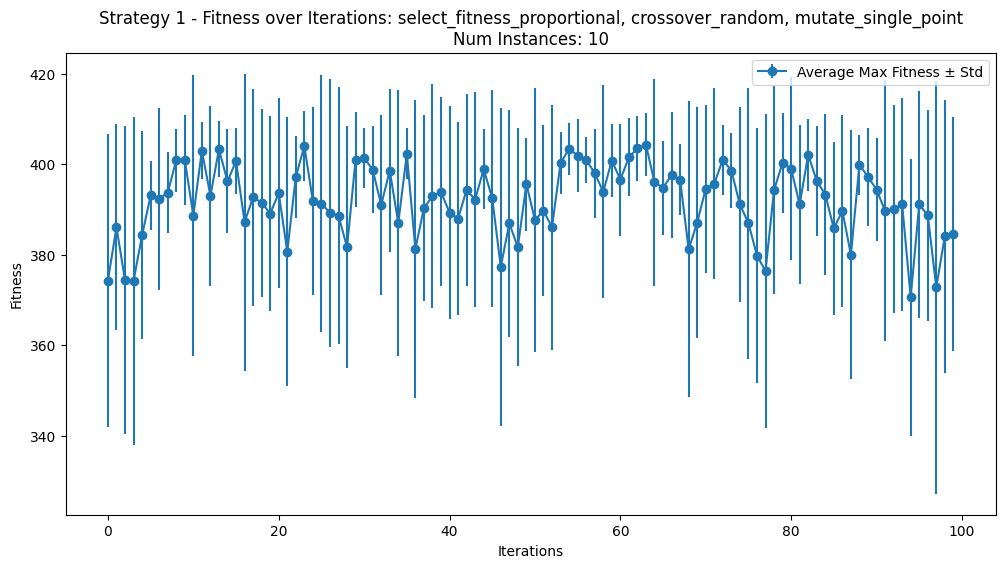

Elapsed Time: 6.51 seconds
----------------------------------------------------------------
Testing strategy2 : select_fitness_proportional, crossover_random, mutate_fitness_proportional
Max Average Fitness: 407.9


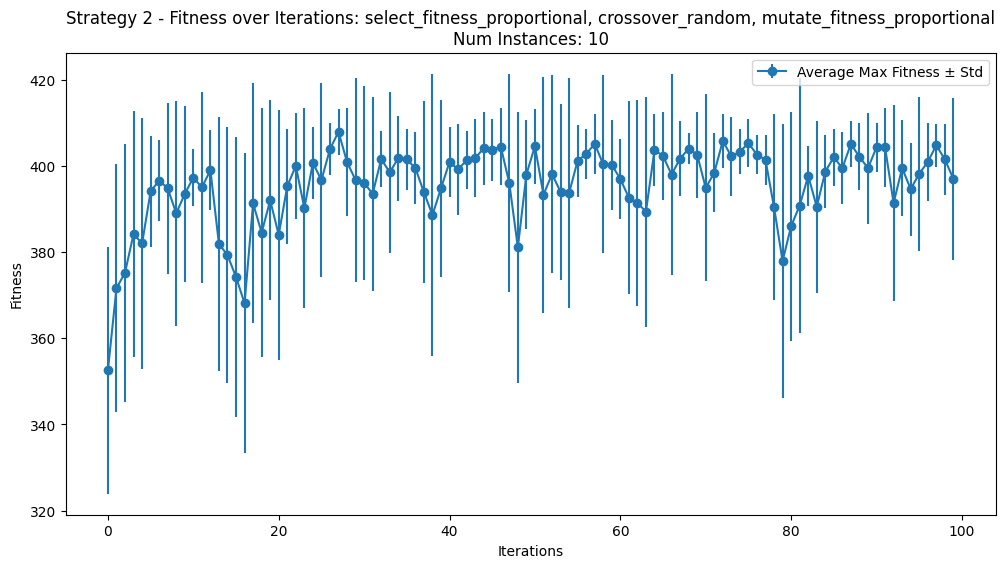

Elapsed Time: 11.17 seconds
----------------------------------------------------------------
Testing strategy3 : select_fitness_proportional, crossover_two_point, mutate_single_point
Max Average Fitness: 405.6


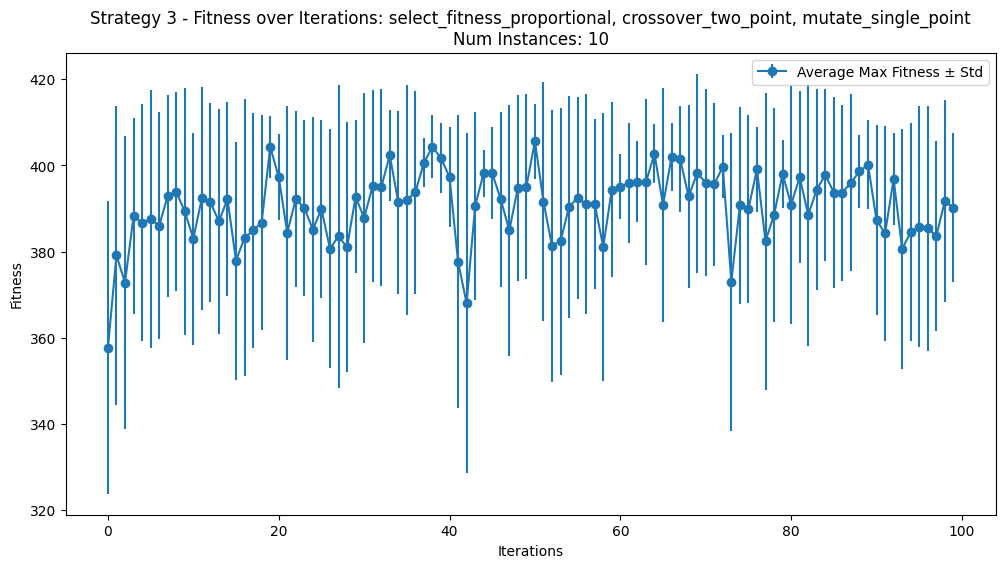

Elapsed Time: 7.01 seconds
----------------------------------------------------------------
Testing strategy4 : select_fitness_proportional, crossover_two_point, mutate_fitness_proportional
Max Average Fitness: 404.2


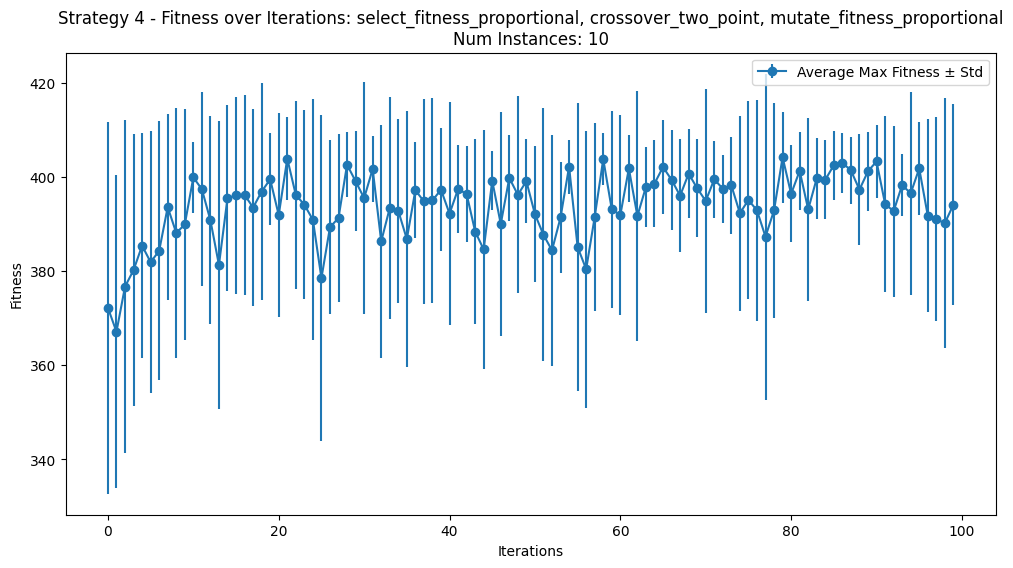

Elapsed Time: 12.08 seconds
----------------------------------------------------------------
Testing strategy5 : select_tournament, crossover_random, mutate_single_point
Max Average Fitness: 412.0


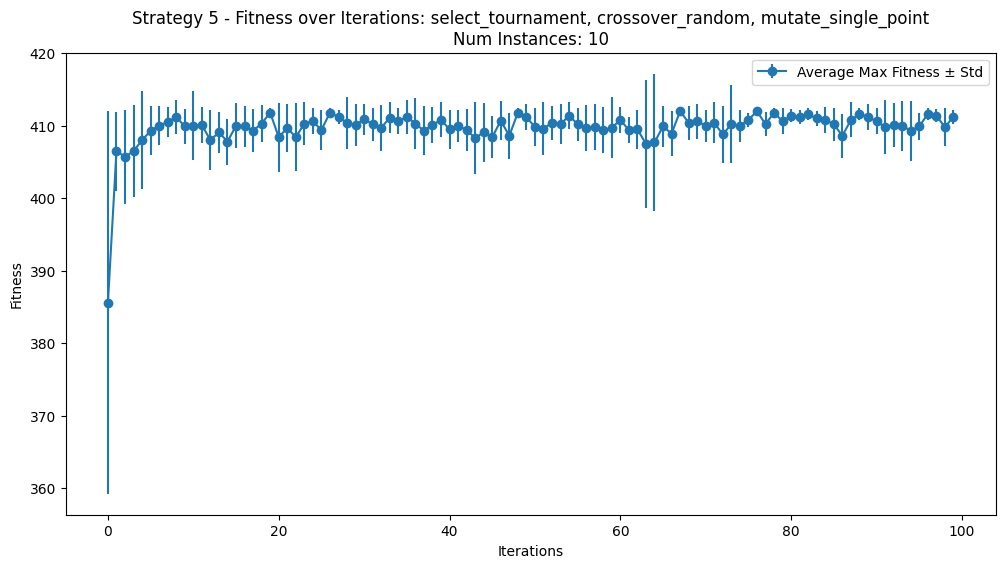

Elapsed Time: 2.99 seconds
----------------------------------------------------------------
Testing strategy6 : select_tournament, crossover_random, mutate_fitness_proportional
Max Average Fitness: 412.0


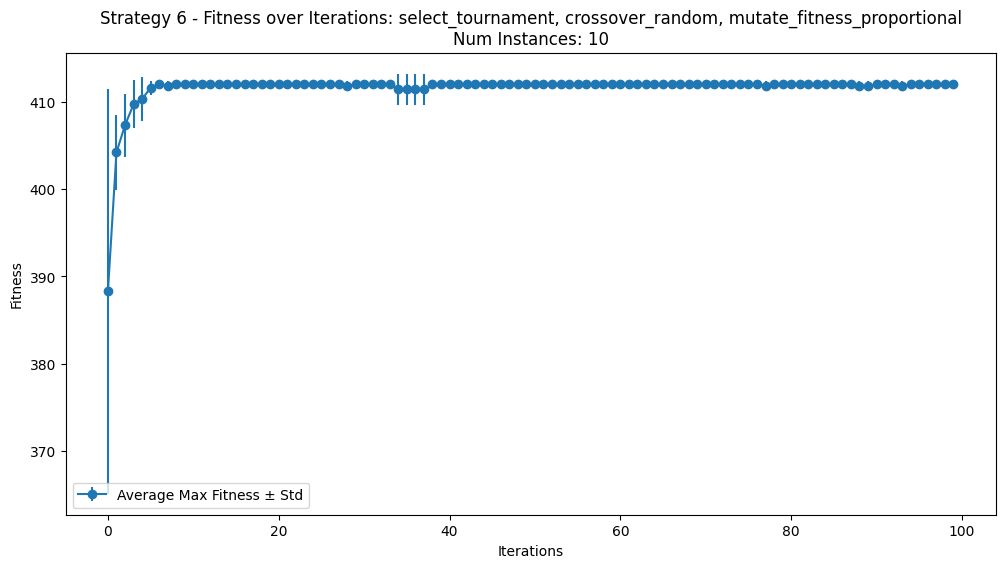

Elapsed Time: 7.95 seconds
----------------------------------------------------------------
Testing strategy7 : select_tournament, crossover_two_point, mutate_single_point
Max Average Fitness: 412.0


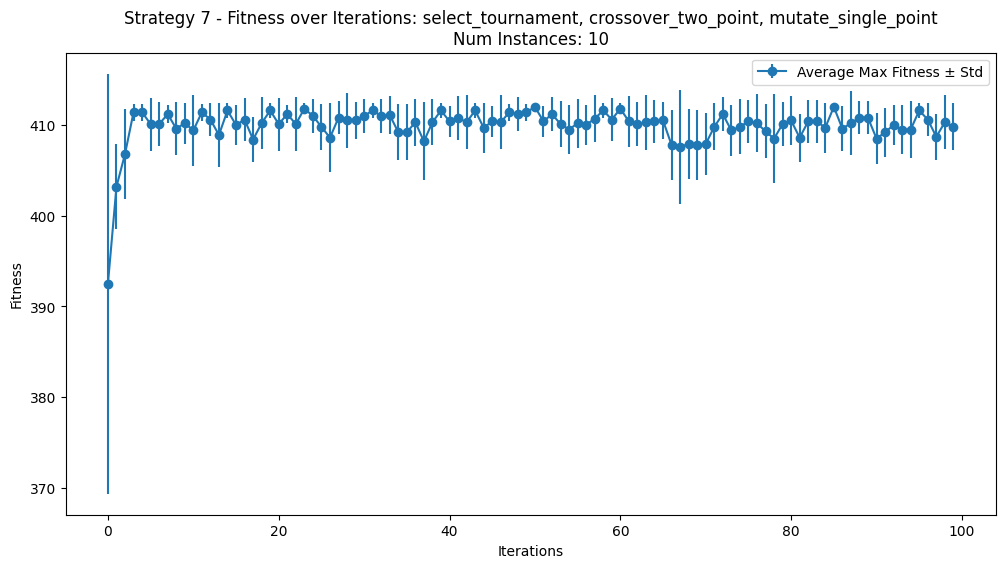

Elapsed Time: 3.36 seconds
----------------------------------------------------------------
Testing strategy8 : select_tournament, crossover_two_point, mutate_fitness_proportional
Max Average Fitness: 412.0


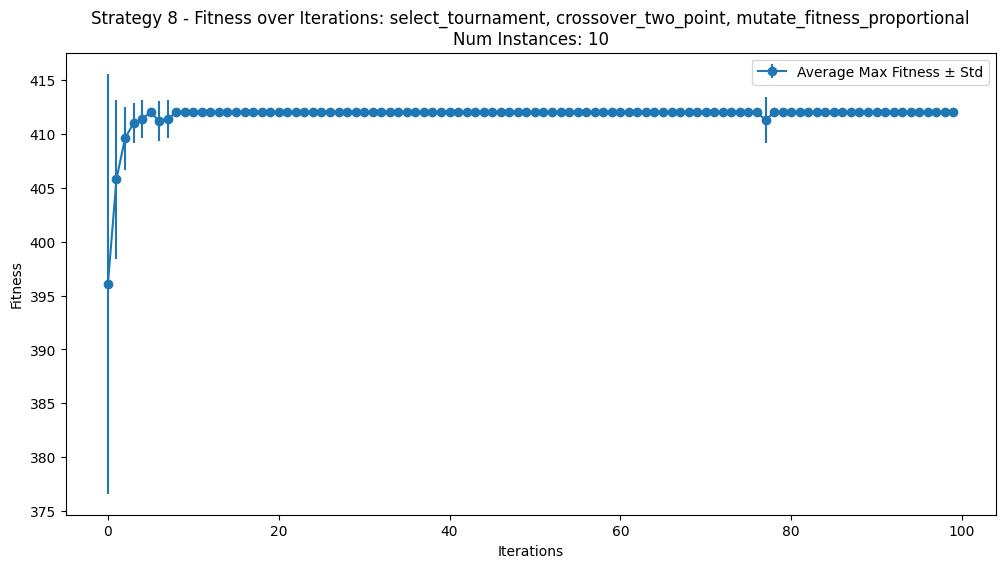

Elapsed Time: 8.58 seconds
----------------------------------------------------------------


In [19]:
# Tester différentes combinaisons de stratégies de sélection, de croisement et de mutation
select_functions = [select_fitness_proportional, select_tournament]
crossover_functions = [crossover_random, crossover_two_point]
mutate_functions = [mutate_single_point, mutate_fitness_proportional]
strategy_index = 1
for select_func in select_functions:
    for crossover_func in crossover_functions:
        for mutate_func in mutate_functions:
            print(f"Testing strategy{strategy_index} : {select_func.__name__}, {crossover_func.__name__}, {mutate_func.__name__}")
            ga = GeneticAlgorithm(parameterSetting, select_func, crossover_func, mutate_func)
            nombre_iteration = 100
            num_instances = 10  # nombre d'instance

            start_time = time.time()
            avg_max_fitness, std_max_fitness = ga.run_multiple_instances(nombre_iteration, num_instances)
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Sortie de la plus grande valeur moyenne obtenue 
            max_avg_fitness = np.max(avg_max_fitness)
            print(f"Max Average Fitness: {max_avg_fitness}")

            # dessiner
            def plot_multiple_instances(ga, avg_max_fitness, std_max_fitness, iterations, num_instances):
                plt.figure(figsize=(12, 6))
                plt.errorbar(range(iterations), avg_max_fitness, yerr=std_max_fitness, label='Average Max Fitness ± Std', fmt='-o')
                plt.xlabel('Iterations')
                plt.ylabel('Fitness')
                plt.title(f'Strategy {strategy_index} - Fitness over Iterations: {select_func.__name__}, {crossover_func.__name__}, {mutate_func.__name__}\nNum Instances: {num_instances}')
                plt.legend()
                plt.show()

            plot_multiple_instances(ga, avg_max_fitness, std_max_fitness, nombre_iteration, num_instances)
            
            # Sortie le temp d'execution
            print(f"Elapsed Time: {elapsed_time:.2f} seconds")
            #print(f"Average Max Fitness: {avg_max_fitness} ± {std_max_fitness}")
            print("----------------------------------------------------------------")
            strategy_index += 1


### B）Comparaison des performances des huit stratégies

Testing strategy1: select_fitness_proportional, crossover_random, mutate_single_point
Max Average Fitness: 405.0
Elapsed Time: 6.28 seconds
----------------------------------------------------------------
Testing strategy2: select_fitness_proportional, crossover_random, mutate_fitness_proportional
Max Average Fitness: 406.9
Elapsed Time: 11.26 seconds
----------------------------------------------------------------
Testing strategy3: select_fitness_proportional, crossover_two_point, mutate_single_point
Max Average Fitness: 404.7
Elapsed Time: 6.36 seconds
----------------------------------------------------------------
Testing strategy4: select_fitness_proportional, crossover_two_point, mutate_fitness_proportional
Max Average Fitness: 407.2
Elapsed Time: 11.06 seconds
----------------------------------------------------------------
Testing strategy5: select_tournament, crossover_random, mutate_single_point
Max Average Fitness: 411.8
Elapsed Time: 2.69 seconds
--------------------------

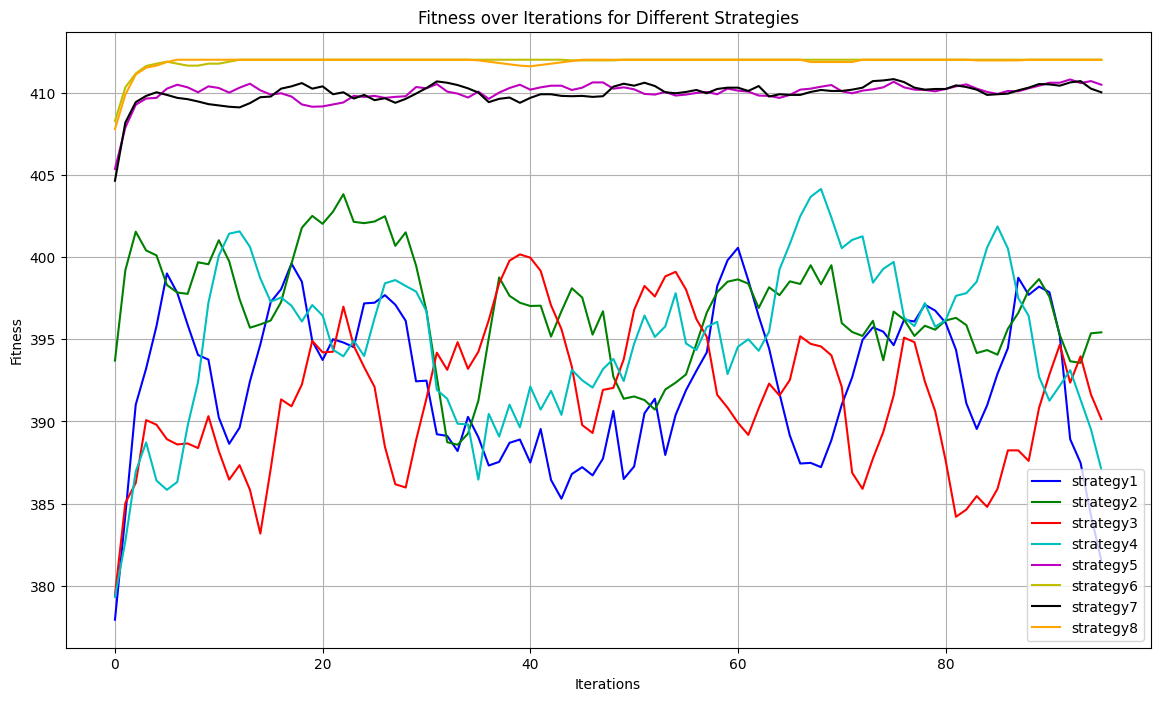

In [20]:
# Tester différentes combinaisons de stratégies de sélection, de croisement et de mutation
strategies = []
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

plt.figure(figsize=(14, 8))

strategy_index = 0

for select_func in select_functions:
    for crossover_func in crossover_functions:
        for mutate_func in mutate_functions:
            strategy_name = f"strategy{strategy_index + 1}"
            print(f"Testing {strategy_name}: {select_func.__name__}, {crossover_func.__name__}, {mutate_func.__name__}")
            ga = GeneticAlgorithm(parameterSetting, select_func, crossover_func, mutate_func)
            nombre_iteration = 100
            num_instances = 10  # nombre d'instance

            start_time = time.time()
            avg_max_fitness, std_max_fitness = ga.run_multiple_instances(nombre_iteration, num_instances)
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Sortie de la plus grande valeur moyenne obtenue 
            max_avg_fitness = np.max(avg_max_fitness)
            print(f"Max Average Fitness: {max_avg_fitness}")

            # Ajouter les données de la stratégie pour le tracé
            strategies.append((strategy_name, avg_max_fitness, std_max_fitness))

            # Sortie le temps d'exécution
            print(f"Elapsed Time: {elapsed_time:.2f} seconds")
            print("----------------------------------------------------------------")

            strategy_index += 1

# Dessiner toutes les stratégies sur le même graphique
for idx, (strategy_name, avg_max_fitness, std_max_fitness) in enumerate(strategies):
    smoothed_fitness = np.convolve(avg_max_fitness, np.ones(5)/5, mode='valid')  # 
    plt.plot(smoothed_fitness, label=strategy_name, color=colors[idx])
    #plt.fill_between(range(len(smoothed_fitness)), smoothed_fitness - std_max_fitness[:len(smoothed_fitness)], 
                     #smoothed_fitness + std_max_fitness[:len(smoothed_fitness)], color=colors[idx], alpha=0.1)

plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness over Iterations for Different Strategies')
plt.legend()
plt.grid(True)
plt.show()

